## Загрузим данные:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KDTree

x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')

X_train = pd.DataFrame(np.load('x_train.npy'))
X_test = pd.DataFrame(np.load('x_test.npy'))

In [5]:
X_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,2014-09-16,5.0,3.25,3710,34200,2.0,False,3,8,2510,1200,1986,0,98074,47.610100,-122.046997
1,2014-11-18,3.0,1.75,2820,8879,1.0,False,5,7,1540,1280,1920,1957,98146,47.509399,-122.375999
2,2014-11-10,3.0,1.00,1240,239144,1.0,False,3,6,1240,0,1921,1992,98038,47.430302,-122.045998
3,2015-04-16,4.0,2.50,2670,8279,2.0,False,3,7,2670,0,1999,0,98148,47.429199,-122.328003
4,2014-07-23,3.0,2.25,2700,4025,2.0,False,4,8,1760,940,1907,0,98122,47.607399,-122.293999


Вообще было бы неплохо разделить train сразу на train и отложенную выборку, но проще везде делать кросс-валидацию

## Plot some data representations

In [9]:
def pairplot(df, target):
    ncol, nrow = 7, df.shape[1] // 7 + (df.shape[1] % 7 > 0)
    plt.figure(figsize=(ncol * 4, nrow * 4))

    for i, feature in enumerate(df.columns):
        plt.subplot(nrow, ncol, i + 1)
        plt.scatter(df[feature], target, s=10, marker='o', alpha=.6)
        plt.xlabel(feature)
        if i % ncol == 0:
            plt.ylabel('target')

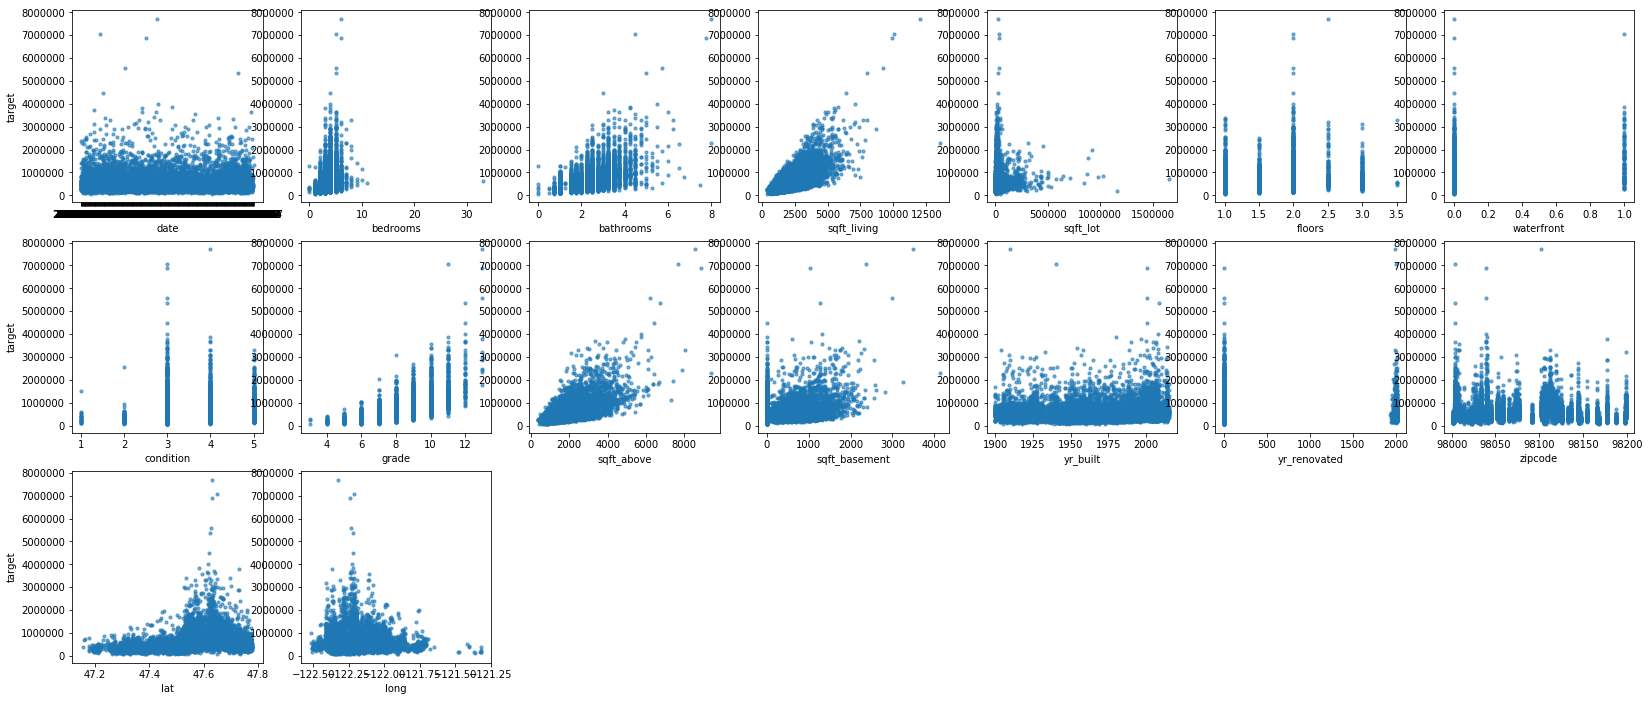

In [11]:
pairplot(X_train, y_train)

Все что мы нарисовали нам нужно, чтоб понять как выглядят вообще фичи, где в них категориальные, где какие и в какую сторону нужно их менять, чтотб используемые линейныйе модели давали лучший скор.

## Transform data:

В этом подразделе будем применять преобрахования к данным, пожалуй это самое интересное в этом контесте.
Давайте по пунктам:
 * Для начала вспомним как выбивали во второй домашке норм скор. Надо было применить какие-то преобразования к признакам так, чтобы получившаяся зависимость была более линейной. Сделаем тоже самое и тут. Подсказкой для этих преобразований служат названия колонок, например если признак содержит `sqft_..`, то кажется от него логичным взять корень.
 * Легко так же заметить, что `sqft_basement` = `sqft_lot` - `sqft_above`, а значит этот признак лишний и может вызывать переобучение - выкинем его. (надеюсь я то из того вычел)
 * Есть очевидно категориальные признаки, такие как `grade` или `condition`. Наверное, первое что приходит в голову, это применить [один горячий энкодер](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) прямо к ним. Но этого недостаточно. На самом деле скрывается еще один категориальный признак - `zipcodes`. Он содержит в себе информацию о районе дома. Такая информация может быть невероятно важна, когда мы оцениваем ценность дома.
 * На каком-то из меинаров говорили, что есть смысл логарифмировать целевую переменную - сделаем это. Смысл в том что предсказывать порядок модели проще, да и нет нужды по сути сказать точно последнюю цифорку, но хорошо бы точно сказать сколько нулей в стоимости.
 * Теперь, полистаем [возможные варианты](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing). Вспомним так же что во второй домашке нам показывали еще один инструмент - [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) c разными степенями. Окей, активируем его. Однако, непонятно, что делать раньше [один горячий энкодер](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) или `PolynomialFeatures`. Это вопрос возникает, когда пытаешься сделать `PolynomialFeatures` высокой степени к преобразованным признакам и ловишь `MEMory Error`. Вообще говоря, логичнее в начале применять экнодер, а потом `PolynomialFeatures`, чтоб в `PolynomialFeatures` появлялись новые осмысленные преобразования  и комбинации этого признака, однако непонятно, может он вообще не имеет смысла в комбинациях и лучше в начале применить ко всем кроме него, а его уже добавить в самом конце преобразованным. Поймем это с помощью грид серча.
 * Отлично, мы что-то сделали, но, спойлер, это привело нас только к скору ~12.5
 * У нас остались неиспользованные фичи - `lat`, `long` и первая логичная идея которая приходит в голову - добавить какую-то группировку по признакам. Эта группировка воообще говоря разумна, так как еще раз показывает модели, что квартиры в абстрактных текстильщиках, дешевле чем на абстрактной фрунзенской набережнойб хотя от центра они удалены одинаково. Можно реализовать много локальных моделей, которые будут учиться на n ближайших домах. Но это муторно. Давайте добавим в данные признак связанный со средней ценой ближайших n домов. Таким образом, мы сделаем наконец сделаем некоторое подобие [Mean Target Encoding](https://github.com/esokolov/ml-course-hse/blob/master/2018-fall/seminars/sem06.pdf)(и почему я не сделал его раньше?), добавим утечку целевой переменной и не будем с этим бороться.
 * Так скор станет близок к ~12.05, чтоб поднять его еще выше вспомним что мы делаем `PolynomialFeatures` и наш новый признак будет умножаться на всякие старые. Поэтому посчитаем не просто среднюю цену n ближайших домов, а поделим ее на разные признаки каждого из ближайших домов. То есть: $\sum\limits_{i=1}^n \frac{target_i}{feature_i}$, где $n$ - количество домов. Сделаем так для `sqft_lot`, `grade`, и `condition`. Почему для них? Прост они мне понравились.

На этом препроцессинг все, посмотрим как оно реализовано.
Будьте осторожны, далее костыли и велосипеды.

In [14]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso, LassoLars, LassoLarsCV, BayesianRidge, ElasticNet, HuberRegressor, ElasticNetCV, SGDRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [15]:
# Not used due to its slowest
# But if you like, you can ran it and wait for jne and half hour while its working
# It's really working, I have checked
# Thank you very much.

from scipy.spatial.distance import euclidean
class MyKDTree():
    def __init__(self, data = None):
        self.data = data
    def fit(self, data):
        self.data = data
    def query(self, point, k = 5):
        if self.data is None:
            raise ValueError('Not fitted yet')
        order = np.argsort([euclidean(data_point, point) for data_point in self.data])
        data_sorted = self.data[order]
        return data_sorted[:k], order[:k]

In [18]:
# для группировки по 'lat' и 'long' будем использовать KDTree
kdtree = KDTree(np.vstack([X_train['lat'], X_train['long']]).T)

In [19]:
grades_indxs = {}
for grade in list(X_train['grade'].unique()):
    grades_indxs[grade] = set(list(X_train.query(f'grade == {grade}').index))

In [13]:
from tqdm import tqdm

# было бы классно сделат класс обертку и использовать его в кросс-валидации, но нет
def add_local_price(data, train, n_neighbours = 25):
    # наверное возник вопрос, почему n_neighbours = 25
    # я это подобрал на train
    # да-да, на той же выборке на которой была утечка целевой переменной, все дела.
    # не стоит так делать

    train_data, train_labels = train
    mean_local_price = []
    mean_local_price_by_sqft = []    
    mean_local_price_by_grade = []
    mean_local_price_by_condition = []
    for lat, long in zip(tqdm(data['lat']), data['long']):
        point = np.array([[lat, long]])
        # находим ближайших
        _, ids = kdtree.query(point, k = n_neighbours)
        ids = ids.flatten()
        ids.sort()
        # считаем нужные статистики
        closest_by_sqft = train_labels[ids] / train_data.iloc[ids, train_data.columns.get_loc('sqft_lot')]
        closest_by_grade = train_labels[ids] / train_data.iloc[ids, train_data.columns.get_loc('grade')]
        closest_by_cond = train_labels[ids] / train_data.iloc[ids, train_data.columns.get_loc('condition')]
        # добавляем среднее
        mean_local_price.append(train_labels[ids].mean())
        mean_local_price_by_sqft.append(closest_by_sqft.mean())
        mean_local_price_by_grade.append(closest_by_grade.mean())
        mean_local_price_by_condition.append(closest_by_cond.mean())
    data['mean_local_price'] = mean_local_price
    data['mean_local_price_by_sqft'] = mean_local_price_by_sqft
    data['mean_local_price_by_grade'] = mean_local_price_by_grade
    data['mean_local_price_by_condition'] = mean_local_price_by_condition

add_local_price(X_train, train=(X_train, np.log(y_train)))
add_local_price(X_test, train=(X_train, np.log(y_train)))

100%|██████████| 6613/6613 [00:08<00:00, 766.06it/s]


In [20]:
# унаследуемся от всего что нужно чтоб вставлять наш класс в пайплайны
class DataTransform(BaseEstimator, TransformerMixin):
    def __init__(self, need_one_hot = True, poly_deg = None, scaler = None):
        self.poly_deg = poly_deg
        if poly_deg is not None:
            self.poly = PolynomialFeatures(degree = poly_deg)
        else:
            self.poly = PolynomialFeatures()
        self.need_one_hot = need_one_hot
        self.scaler = scaler
        
    def parser(self, data):
        def take_year(house):
            return (int(house.split('-')[0]) - 2014) * 365 + int(house.split('-')[1]) * 30 + int(house.split('-')[2])
        # начнем с самого главного и полезного преобразования
        # оно радикально подняло качество модели (нет)
        data['waterfront'] = data['waterfront'] * 10
        
        # расстояние до самого дорого здания, с ним было получше
        data['long2'] = np.abs(data['long'] - self.best_long)
        data['lat2'] = np.abs(data['lat'] - self.best_lat)
        
        data['date'] = data['date'].apply(take_year)

        # некоторые нелинейности
        data['sqft_living2'] = np.sqrt(data['sqft_living'])
        data['sqft_lot2'] = np.sqrt(data['sqft_lot'])
        data['sqft_above2'] = np.sqrt(data['sqft_above'])
        data['floors2'] = data['floors'] ** 2
        data['bedrooms2'] = data['bedrooms'] ** 2
        data['grade2'] = data['grade'] ** 2
    
        # насколько дачный у нас участок:
        data['countryside_coef'] = data['sqft_living2'] / data['sqft_lot2']
        
        # будем считать что если дом был реконструирован, то его новая дата постройки 
        #                                         - среднее арифметическое старой и года реконструкции
        data['yrs'] = (data['yr_built'] + data['yr_renovated'] + (data['yr_renovated'] == 0) * data['yr_built']) / 2
        # будем считать что дома старше 1905 начинаю снова возрастать в цене
        data['yrs'] = np.sqrt(np.abs(data['yrs'] - 1905))
        # уберем лишнее
        data.drop(columns=['sqft_basement', 'yr_renovated', 'yr_renovated'], inplace=True)
        
    def fit(self, X, y):
        self.best_long = X.iloc[np.argmax(y), X.columns.get_loc('long')]
        self.best_lat = X.iloc[np.argmax(y), X.columns.get_loc('lat')]
        return self

    def transform(self, X_):
        X = X_.copy()
        self.parser(X)
        
        # здесь очень странный код:
        # он делает в зависимости от параметров либо в начале горячий энкодер, а потом poly, либо наоборот
        # и иногда scaler добавляет
        
        if self.poly_deg is not None:
            if self.need_one_hot:
                df_zipcodes = pd.DataFrame(X['zipcode'])
                df_zipcodes = pd.get_dummies(df_zipcodes, columns=['zipcode'])
            if self.scaler is not None:
                X = self.scaler.fit_transform(X.drop(columns = ['zipcode']))
                X = self.poly.fit_transform(X)
            else:
                X = self.poly.fit_transform(X.drop(columns = ['zipcode']))
            if self.need_one_hot:
                X = np.hstack((X, df_zipcodes.values))
        else:
            if self.need_one_hot:
                X = pd.get_dummies(X, columns=['zipcode'])
            if self.scaler is not None:
                X = self.scaler.fit_transform(X)
            X = self.poly.fit_transform(X)
        return X

## Train model and test it using CV

Use `polinomial features` and `diffrent regressions` for better result

In [21]:
class Mix_Transformers(BaseEstimator, TransformerMixin):
    def __init__(self, name = 'std'):
        self.models = {'std': StandardScaler(),
                       'min_max': MinMaxScaler(),
                       'robust': RobustScaler()}
        self.name = name
    
    def fit(self, X, *args, **kwargs):
        if self.name is not None:
            self.models[self.name].fit(np.nan_to_num(X), *args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        if self.name is not None:
            np.nan_to_num(X, copy = False)
            return self.models[self.name].transform(X, **transform_params)
        return X

In [22]:
full_lasso = Pipeline([
    ('transf', DataTransform()),
    ('scalers', Mix_Transformers()),
    ('estimator', Lasso())
])

full_ridge = Pipeline([
    ('transf', DataTransform()),
    ('scalers', Mix_Transformers()),
    ('estimator', Ridge())
])

full_HR = Pipeline([
    ('transf', DataTransform()),
    ('scalers', Mix_Transformers()),
    ('estimator', HuberRegressor())
])

# Таких было очень много, буквально для каждого эстиматора
full_grid_HR = {'estimator__alpha': np.logspace(-1, 4, 10), 'estimator__max_iter' : [1500],
             'scalers__name' : ['std', 'min_max'], 'transf__poly_deg' : [None, 3], 'transf__scaler' : [None]}

In [19]:
# metric from contest:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
# пример такого грид серча:
grid_HR = GridSearchCV(full_HR, full_grid_HR, scoring=make_scorer(mape, greater_is_better=False),n_jobs=-1, verbose=2)
grid_HR.fit(X_train, y_train)
grid_HR.best_score_, grid_HR.best_params_

In [23]:
# из них были выбраны наиболее мощные:
lasso = make_pipeline(DataTransform(), StandardScaler(), Lasso(alpha=1e-3, max_iter=5000))
ENet2 = make_pipeline(DataTransform(), StandardScaler(), ElasticNet(alpha=0.00035, max_iter=1700))
ENet3 = make_pipeline(DataTransform(), StandardScaler(), ElasticNet(alpha=1e-3, max_iter=1700))
HR = make_pipeline(DataTransform(), StandardScaler(), HuberRegressor(alpha=1000, max_iter=1700))
HR3 = make_pipeline(DataTransform(), StandardScaler(), HuberRegressor(alpha=1200, max_iter=1700))
ridge = make_pipeline(DataTransform(poly_deg=3), StandardScaler(), Ridge(alpha=1200, max_iter=1700))

## Apply our model and save result

In [23]:
def saver(path, res):
    with open(path, 'w') as out:
        print('Id,Price', file = out)
        for i in range(len(res)):
            print('{i},{res}'.format(i = i + 1, res=res[i]), file = out)

In [25]:
# new ultra top method for averaging results of diffrent models:
# import asyncio
from tqdm import tqdm

# чтоб еще больше поднять резалт, возьмем среднее предсказание по лучшим моделям
# снова унаследуемся от всех

# source: https://www.kaggle.com/alexpengxiao/preprocessing-model-averaging-by-xgb-lgb-1-39
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        #loop = asyncio.get_event_loop()
        
        # Train cloned base models
        for model in tqdm(self.models_):
            model.fit(X, y)

        return self
    
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in tqdm(self.models_)
        ])
        return np.mean(predictions, axis=1)   

In [ ]:
y_train = np.log(y_train)
averaged_models = AveragingModels(models = (HR, ENet2, HR3, ENet3))
LR = averaged_models.fit(X_train, y_train)
res = LR.predict(X_test)
# заметим, что метрика из контеста несимметрична и штрафует за ошибки ввверх более чем за ошибки вниз
# воспользуемся этим:
res = np.exp(res) * 0.99
saver('res_weighted_averaged_8.csv', res)